In [ ]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

In [27]:
# Load the label file
label_file_path = r'C:\Dev\Smart-Cities-Project\model\labels.csv'
label_data = pd.read_csv(label_file_path)

# Load the trained model
model = load_model(r'C:\Dev\Smart-Cities-Project\model\my_traffic_sign_model.h5')  # Adjust the path as needed


c:\Dev\Smart-Cities-Project\smart_cities\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Dev\Smart-Cities-Project\smart_cities\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [28]:
# Preprocessing functions
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100, 100))
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255.0
    return img

In [29]:
# Load the trained model
model = load_model(r'C:\Dev\Smart-Cities-Project\model\my_traffic_sign_model.h5')  # Adjust the path as needed

# Function to preprocess and predict a single image from a given path
def classify_single_image(image_path, model, label_data):
    # Read the image from the given path
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or unable to read")
    
    # Preprocess the image using existing functions
    img_preprocessed = preprocessing(img)
    
    # Expand dimensions for model input (1, 100, 100, 1)
    img_input = np.expand_dims(img_preprocessed, axis=0)
    img_input = np.expand_dims(img_input, axis=-1)
    
    # Make prediction
    predictions = model.predict(img_input)
    
    # Get the predicted class index and confidence
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    
    # Map class index to class name using the labels file
    predicted_class_name = label_data[label_data['ClassId'] == predicted_class_index]['Name'].values[0]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(grayscale(img), cmap='gray')
    plt.title(f"Class: {predicted_class_name}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()
    
    return predicted_class_name, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


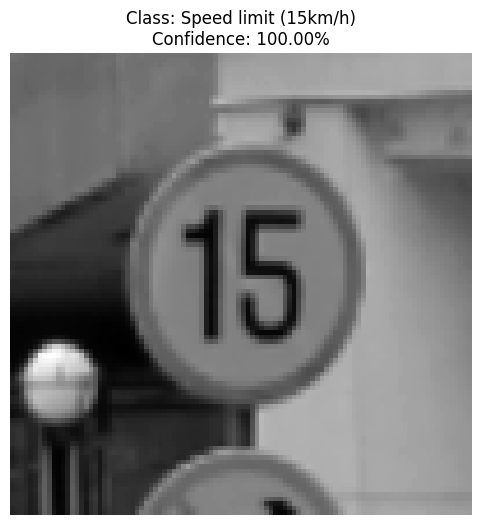

Predicted Class: Speed limit (15km/h)
Confidence: 100.00%


In [30]:
# Example usage
image_path = r'C:\Dev\Smart-Cities-Project\testing-dataset\speed-limit-15.jpg'
class_name, confidence = classify_single_image(image_path, model, label_data)
print(f"Predicted Class: {class_name}\nConfidence: {confidence:.2f}%")

In [31]:
# Function to process and display live video with real-time traffic sign detection
def process_live_video(model, label_data, confidence_threshold=0.7, camera_index=0):
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        print("Error: Could not open camera")
        return

    print("Starting video feed... Press 'q' to quit")

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break

            # Resize the frame for detection (for this example, we will use the entire frame)
            processed_frame = preprocessing(frame)
            img_input = np.expand_dims(processed_frame, axis=0)
            img_input = np.expand_dims(img_input, axis=-1)

            # Make prediction
            predictions = model.predict(img_input, verbose=0)
            predicted_class_index = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class_index]

            # Display predictions if confidence is above threshold
            if confidence >= confidence_threshold:
                predicted_class_name = label_data[label_data['ClassId'] == predicted_class_index]['Name'].values[0]

                # Draw a rectangle and label on the frame
                cv2.rectangle(frame, (50, 50), (300, 300), (0, 255, 0), 2)
                cv2.putText(frame, f"{predicted_class_name}", (60, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(frame, f"Confidence: {confidence * 100:.1f}%", (60, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Display the processed frame
            cv2.imshow('Traffic Sign Detection', frame)

            # Press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()

# Start the video feed and detection
process_live_video(model, label_data, camera_index=0)

Starting video feed... Press 'q' to quit


In [32]:
import cv2
import numpy as np
import time
from collections import deque

def preprocess_frame(frame):
    """Preprocesses a frame for model input."""
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (100, 100))
    equalized_frame = cv2.equalizeHist(resized_frame)
    normalized_frame = equalized_frame / 255.0
    return normalized_frame

def draw_bounding_boxes(frame, boxes, labels):
    """Draws bounding boxes around detected regions in the frame."""
    for (x, y, w, h, label, confidence) in boxes:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f"{label} ({confidence:.1f}%)", (x, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

def process_live_video(model, labelfile, confidence_threshold=0.5, camera_index=0):
    """Process live video feed and classify traffic signs in real-time."""
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        print("Error: Could not open camera")
        return

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    pred_buffer = deque(maxlen=5)  # Store last 5 predictions
    
    fps_start_time = time.time()
    fps_counter = 0
    fps = 0
    
    print("Starting video feed... Press 'q' to quit")

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break

            display_frame = frame.copy()

            # Preprocess the frame for model input
            processed_frame = preprocess_frame(frame)
            processed_frame = np.expand_dims(processed_frame, axis=0)
            processed_frame = np.expand_dims(processed_frame, axis=-1)

            # Make prediction
            predictions = model.predict(processed_frame, verbose=0)
            pred_index = np.argmax(predictions[0])
            confidence = predictions[0][pred_index]

            if confidence >= confidence_threshold:
                # Get the predicted label
                predicted_label = labelfile['Name'][int(pred_index)]

                # Draw the bounding box and label on the frame
                x, y, w, h = 100, 100, 100, 100  # Adjust these values as per detection
                boxes = [(x, y, w, h, predicted_label, confidence * 100)]
                draw_bounding_boxes(display_frame, boxes, labelfile)

            # Calculate and display FPS
            fps_counter += 1
            if (time.time() - fps_start_time) > 1:
                fps = fps_counter
                fps_counter = 0
                fps_start_time = time.time()
            
            cv2.putText(display_frame, f"FPS: {fps}", 
                        (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (0, 255, 0), 2)

            # Display frame with bounding boxes and predictions
            cv2.imshow('Traffic Sign Detection', display_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    finally:
        cap.release()
        cv2.destroyAllWindows()

def start_detection(model, labelfile, camera_index=0):
    """Wrapper function to start the traffic sign detection with error handling"""
    try:
        print("Initializing traffic sign detection...")
        print("Controls:")
        print("- Press 'q' to quit")
        print("- The detection will show signs when confidence is above 70%")
        print("\nStarting camera feed...")
        
        process_live_video(model, labelfile, camera_index=camera_index)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Cleaning up...")
        cv2.destroyAllWindows()

In [33]:
start_detection(model, label_data, camera_index=0) 

Initializing traffic sign detection...
Controls:
- Press 'q' to quit
- The detection will show signs when confidence is above 70%

Starting camera feed...
Starting video feed... Press 'q' to quit
